<a href="https://colab.research.google.com/github/SoniaSong826/CAREN_OpenSim_Pipeline/blob/master/CAREN_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CAREN OpenSim Pipeline**


---
## **Introduction:**

This pipeline follows these **nine steps** (refer to the following flow chart):

***STEP 1 Conversion***: Use collected data (`.c3d`) files to generate `.trc`, `.mot` and EMG (`.sto`)files

***STEP 2 Scaling***: Scale the generic model (`.osim`) to generate scaled model fot the specific subject

***STEP 3 IK***: Inverse kinematics

***STEP 4 ID***: Inverse dynamics 

***STEP 5 RRA***: Residual reduction algorithm

***STEP 6 SO***: Eventually we can do static optimization for predicting muscle forces/activations

***STEP 7 MA & JRA***: Analysis toos for muscle analysis and joint reaction force

We follow the process suggested by OpenSim and validate every step as we make progress.

---
## **Authors:**

This project is an internship task of **CAREN lab** in The University of Melbourne.

**Intern:** Sonia Song 

**Supervisor:** Hossein Mokhtarzadeh

---
## **Related Links:**

Github Link for this page: https://github.com/SoniaSong826/CAREN_OpenSim_Pipeline

OpenSim:  https://github.com/opensim-org/opensim-core

Pyosim: https://github.com/pyomeca/pyosim

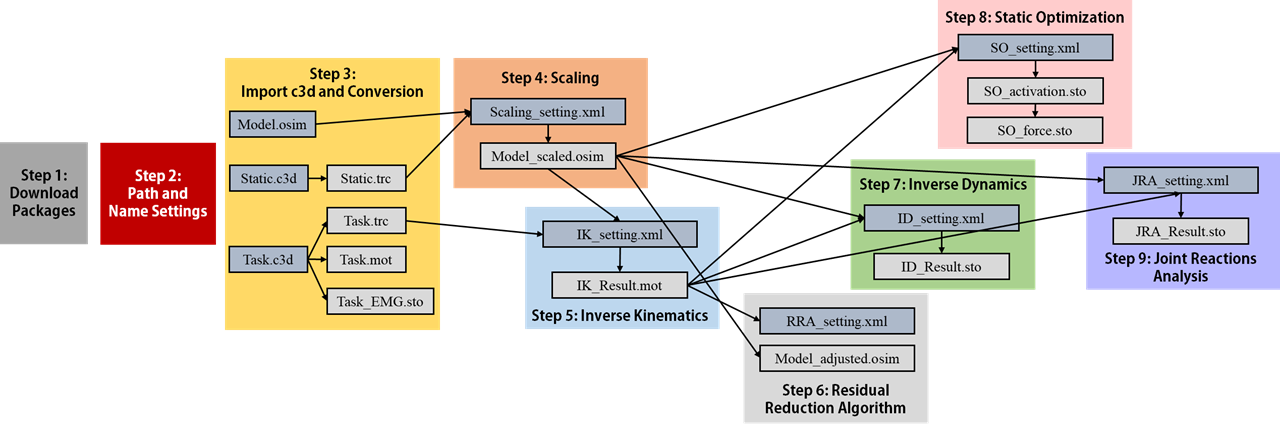



---


# 1.Download and Install Packages


---
Firstly, install all the packages and build the environment we need.
1. **ezc3d**: Easy to use C3D reader/writer for C++, Python and Matlab https://github.com/pyomeca/ezc3d
2. **pyomeca**: Python toolbox for biomechanics analysis   https://github.com/pyomeca
3. **OpenSim**: SimTK OpenSim C++ libraries and command-line applications, and Java/Python wrapping. https://github.com/opensim-org/opensim-core
4. **Pyosim**: Interface between OpenSim and the Pyomeca library. https://github.com/pyomeca/pyosim


In [2]:
# Install miniconda environment and dependancies
!wget -c https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local

import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

# Download and install desired packages
!conda install -y --prefix /usr/local -c pyomeca -c conda-forge pyomeca

# install OpenSim via kzts
!conda install -y --prefix /usr/local -c kzts opensim


# install OpenSim via mrtnz
# !conda install -y --prefix /usr/local -c mrtnz opensim
# or via py
#!conda install -y --prefix /usr/local -c pyomeca opensim

#install pyosim to interface py and opensim
!conda install pyosim -c pyomeca

# Enjoy the packages
import ezc3d as c3d
import pyomeca as pm
import opensim as osim
import pyosim 

--2020-05-05 08:44:41--  https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85055499 (81M) [application/x-sh]
Saving to: ‘Miniconda3-latest-Linux-x86_64.sh’

Miniconda3-latest-L 100%[===================>]  81.12M   211MB/s    in 0.4s    

2020-05-05 08:44:42 (211 MB/s) - ‘Miniconda3-latest-Linux-x86_64.sh’ saved [85055499/85055499]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - \ done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==1.3.0=py37_0
    - ca-certificates==2020.1.1=0
    - certifi==2019.11.28=py37_0
    - cffi==1.14.0=py37h2e261b9_0
    - chardet==3.0.4=py37_1003
    - conda-package-handling==1.6.0=py37h7b6447c_0
  



---


# 2.Path Settings


---


Set input path and create folders for later work

**VERY IMPORTANT!!** 

Simply set the input file for **ALL** later work ;-)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os

input_dir = os.path.abspath('/content/drive/My Drive/CAREN_Pipeline/')

## **Step 2.1：Construct Folder Structure**

**Input:** 
1. Table for subjects' information(`.mat`)
2. Path with all folders for subjects' data and requirements.

This section will extract the information for subjects from the `.mat` file for later work and print them.
And then create folders and copy `.xml` files to corresponding setup folders.

In [0]:
from scipy.io import loadmat
import string
import shutil

def create_folder(folder_path):
    if os.path.exists(folder_path):
      return
    else:
        os.mkdir(folder_path)

def create_pipeline_folders(subject):
    #create_folder(os.path.join(test_dir, subject, 'c3d_Files'))  
    create_folder(os.path.join(test_dir, subject, 'trc_Files'))  
    create_folder(os.path.join(test_dir, subject, 'grf_mot_Files')) 
    create_folder(os.path.join(test_dir, subject, 'EMG_sto_Files')) 
    create_folder(os.path.join(test_dir, subject, 'Scale_Setup'))      
    create_folder(os.path.join(test_dir, subject, 'Scale_Result'))
    create_folder(os.path.join(test_dir, subject, 'IK_Setup'))      
    create_folder(os.path.join(test_dir, subject, 'IK_Result'))  
    create_folder(os.path.join(test_dir, subject, 'ID_Setup'))      
    create_folder(os.path.join(test_dir, subject, 'ID_Result'))  
    create_folder(os.path.join(test_dir, subject, 'RRA_Setup'))      
    create_folder(os.path.join(test_dir, subject, 'RRA_Result'))
    create_folder(os.path.join(test_dir, subject, 'SO_Setup'))      
    create_folder(os.path.join(test_dir, subject, 'SO_Result'))
    create_folder(os.path.join(test_dir, subject, 'JRA_Setup'))      
    create_folder(os.path.join(test_dir, subject, 'JRA_Result'))
    

def move_xmlfiles(requirements_dir, subject):
    all_xmls = os.listdir(requirements_dir)
    for file in all_xmls:
        xml_file = os.path.join(requirements_dir, file)
        if 'Scale' in file:
            shutil.copy(xml_file, os.path.join(test_dir, subject, 'Scale_Setup'))
        if 'IK' in file:
            shutil.copy(xml_file, os.path.join(test_dir, subject, 'IK_Setup'))
        if 'ID' in file:
            shutil.copy(xml_file, os.path.join(test_dir, subject, 'ID_Setup'))
        if 'RRA' in file:
            shutil.copy(xml_file, os.path.join(test_dir, subject, 'RRA_Setup'))
        if 'SO' in file:
            shutil.copy(xml_file, os.path.join(test_dir, subject, 'SO_Setup'))
        if 'JRA' in file:
            shutil.copy(xml_file, os.path.join(test_dir, subject, 'JRA_Setup'))

def list_c3d_tasks(subject):
    print(f"\n----------------------TASK FOR {subject}----------------------")
    list_of_tasks = []
    all_c3ds = os.listdir(os.path.join(test_dir, subject, 'c3d_Files'))
    for file in all_c3ds:
        if 'Calibration' not in file:
            list_of_tasks.append(file)
    for task in list_of_tasks:
        print(task)

def get_stubject_names(mat_file):
    subject_data = mat_file['first2SubjData']
    num_of_subjects = subject_data['name'].size
    list_of_subject_names=[]

    for i in range(num_of_subjects):
        name=subject_data['name'][0,i][0][0][0]
        list_of_subject_names.append(name)
    
    return list_of_subject_names

def get_stubject_info(mat_file):

    subject_data = mat_file['first2SubjData']
    num_of_subjects = subject_data['name'].size
    list_of_subject_info=[]

    for i in range(num_of_subjects):
        name=subject_data['name'][0,i][0][0][0]
        height = subject_data['data'][0,i][0][0][1][0][0]
        mass = subject_data['data'][0,i][0][0][2][0][0]
        age = subject_data['data'][0,i][0][0][4][0][0]
        info_tuple = [name, height, mass, age]
        list_of_subject_info.append(info_tuple)

    return list_of_subject_info

def get_height_by_name (subject_name, info_tuple):
    for subject in info_tuple:
        if subject_name == subject[0]:
            return int(subject[1]*100)

def get_mass_by_name (subject_name, info_tuple):
    for subject in info_tuple:
        if subject_name == subject[0]:
            return int(subject[2])


def organize_print_file (input_dic, mat_file):
    subject_data = mat_file['first2SubjData']
    num_of_subjects = subject_data['name'].size
    list_of_subject_info=[]

    print("----------------------INFORMATION OF SUBJECTS----------------------")
    for i in range(num_of_subjects):
        name=subject_data['name'][0,i][0][0][0]
        height = subject_data['data'][0,i][0][0][1][0][0]
        mass = subject_data['data'][0,i][0][0][2][0][0]
        age = subject_data['data'][0,i][0][0][4][0][0]
        info_tuple = [name, height, mass, age]
        list_of_subject_info.append(info_tuple)
        print(f"Index : {i+1}  Name : {name}  Height : {height}  Mass : {mass}  Age : {age}")

    all_folders = os.listdir(input_dic)
    for i in range(num_of_subjects):
        for file in all_folders:
            if file == list_of_subject_info[i-1][0]:
                subject_name = list_of_subject_info[i-1][0]
                create_pipeline_folders(subject_name)
                move_xmlfiles(os.path.join(input_dic, 'requirements'),subject_name)
                list_c3d_tasks(subject_name)

mat_file = loadmat(os.path.join(input_dir,'TEST','matTable', 'all2SubjectData.mat'))
test_dir = os.path.abspath('/content/drive/My Drive/CAREN_Pipeline/TEST')
organize_print_file(test_dir, mat_file)


----------------------INFORMATION OF SUBJECTS----------------------
Index : 1  Name : AH  Height : 1.75  Mass : 72  Age : 23
Index : 2  Name : AK  Height : 1.89  Mass : 78  Age : 28

----------------------TASK FOR AH----------------------
S+T01.c3d
S+T02.c3d
S+T03.c3d
W1+L+ACC.c3d
W1+T01.c3d




---


# 3.File Conversion


---
Import c3d file and generate `.trc`, `.mot` and `.sto`

1. Convert c3d file to .trc file(markers' trajectories) and .mot file (Ground force date). 
2. Export EMG data as .sto file and plot them as line charts
3. Save three files in folder named 'ConvertionResult'

## **Step 3.1: Import c3d and show general info**

In [0]:
T = pyosim.Model(os.path.join(input_dir, 'model','test1.osim'))

T.strengthen(10,'test1.osim')

from pathlib import Path
from pyomeca import Analogs3d, Markers3d

def print_marker_analog_data (c3d_file):
    # reading markers' data
    markers_c3d = Markers3d.from_c3d(c3d_file)
    # reading analog data
    analogs_c3d = Analogs3d.from_c3d(c3d_file)
    # output related information
    print("------------MARKER------------")

    print(f"unit: {markers_c3d.get_unit}")

    print(f"rate: {markers_c3d.get_rate} Hz")

    print(f"num markers: {markers_c3d.get_num_markers()}")

    print(f"labels: {markers_c3d.get_labels}")

    print(f"2d labels: {markers_c3d.get_2d_labels()}")

    print(f"first frame: {markers_c3d.get_first_frame}")

    print(f"last frame: {markers_c3d.get_last_frame}")

    print(f"num frames : {markers_c3d.get_num_frames()}")

    #print(f"time frame: {markers_c3d.get_time_frames}")

    print("------------ANALOG------------")

    print(f"unit: {analogs_c3d.get_unit}")

    print(f"rate: {analogs_c3d.get_rate} Hz")

    print(f"labels: {analogs_c3d.get_labels}")

    print(f"shapes: {analogs_c3d.shape}")

    print(f"first frame: {analogs_c3d.get_first_frame}")

    print(f"last frame: {analogs_c3d.get_last_frame}")

    print(f"num frames : {analogs_c3d.get_num_frames()}")


c3d_file = os.path.join(input_dir, 'c3dFile', 'S+T01.c3d')
print_marker_analog_data(c3d_file)


test1.osim created
------------MARKER------------
unit: mm
rate: 100.0 Hz
num markers: 31
labels: ['platform1', 'platform2', 'platform3', 'LASIS', 'RASIS', 'LPSIS', 'RPSIS', 'LLTHI', 'LLEK', 'LMEK', 'LLSHA', 'LLM', 'LMM', 'LHEE', 'LMT2', 'LMT5', 'RLTHI', 'RLEK', 'RMEK', 'RLSHA', 'RLM', 'RMM', 'RHEE', 'RMT2', 'RMT5', 'C7', 'T10', 'XIPH', 'gamepad1', 'gamepad2', 'gamepad3']
2d labels: ['platform1_X', 'platform1_Y', 'platform1_Z', 'platform2_X', 'platform2_Y', 'platform2_Z', 'platform3_X', 'platform3_Y', 'platform3_Z', 'LASIS_X', 'LASIS_Y', 'LASIS_Z', 'RASIS_X', 'RASIS_Y', 'RASIS_Z', 'LPSIS_X', 'LPSIS_Y', 'LPSIS_Z', 'RPSIS_X', 'RPSIS_Y', 'RPSIS_Z', 'LLTHI_X', 'LLTHI_Y', 'LLTHI_Z', 'LLEK_X', 'LLEK_Y', 'LLEK_Z', 'LMEK_X', 'LMEK_Y', 'LMEK_Z', 'LLSHA_X', 'LLSHA_Y', 'LLSHA_Z', 'LLM_X', 'LLM_Y', 'LLM_Z', 'LMM_X', 'LMM_Y', 'LMM_Z', 'LHEE_X', 'LHEE_Y', 'LHEE_Z', 'LMT2_X', 'LMT2_Y', 'LMT2_Z', 'LMT5_X', 'LMT5_Y', 'LMT5_Z', 'RLTHI_X', 'RLTHI_Y', 'RLTHI_Z', 'RLEK_X', 'RLEK_Y', 'RLEK_Z', 'RMEK_X', 'RM

## Step 3.2: Generate three files to conversionResult

Some help functions to convert c3d to trc and mot

Refer to the code on OpenSim Forum:
https://simtk.org/plugins/phpBB/viewtopicPhpbb.php?f=91&t=11493&p=32162&start=0&view=

In [0]:
# Utility functions.
#
# author: Dimitar Stanev <jimstanev@gmail.com>
##
import re
import os
import opensim
import numpy as np
import pandas as pd
from scipy import linalg
from scipy import signal
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.offsetbox import AnchoredText


def calculate_emg_linear_envelope(x, f_sampling=1000, f_band_low=30,
                                  f_band_high=300, f_env=6, to_normalize=False):
    """Calculates the EMG linear envelope by applying the following transformations
    to the raw signal:

    1) Remove mean
    2) Band-pass 4th order Butterworth filter to remove low and high frequencies
    3) Full rectification (use of abs)
    4) Normalization based on max value (if to_normalize=True)
    5) Low-pass filter to calculate the envelope

    """
    f_nyq = f_sampling / 2
    # 1) remove mean
    y = x - x.mean()
    # 2) band-pass
    b, a = signal.butter(4, [f_band_low / f_nyq, f_band_high / f_nyq], 'band')
    y = signal.filtfilt(b, a, y)
    # 3) rectify
    y = np.abs(y)
    # 4) normalize
    if to_normalize:
        y = y / y.max()

    # 5) low-pass
    b, a = signal.butter(2, f_env / f_nyq, 'low')
    env = signal.filtfilt(b, a, y)
    # # plot
    # plt.figure()
    # plt.plot(y, label='raw')
    # plt.plot(env, label='envelop')
    # plt.legend()
    # return
    return env


def normalize_interpolate_dataframe(df, interp_column='time', method='linear'):
    """Normalizes time between [0, 1] and then re-samples data frame at
    constant interval.

    """
    # normalize between 0, 1
    time_old = df.time.to_numpy()
    time_new = (time_old - time_old[0]) / (time_old[-1] - time_old[0])
    df.loc[:, 'time'] = time_new
    # re-sample time with specific interval
    df = df.set_index(interp_column)
    at = np.arange(0, 1.01, 0.01)
    df = df.reindex(df.index | at)
    df = df.interpolate(method=method).loc[at]
    df = df.reset_index()
    df = df.rename(columns={'index': interp_column})
    return df


def extract_gait_cycle_intervals(c3d_file_path):
    """Extracts gait cycle intervals from .c3d file.

    Parameters
    ----------
    c3d_file_path: file path

    Returns
    -------
    tuple: right and left leg intervals

    """
    c3d = btk.btkAcquisitionFileReader()
    c3d.SetFilename(c3d_file_path)
    c3d.Update()
    acq = c3d.GetOutput()
    fps = acq.GetPointFrequency()
    first_frame = acq.GetFirstFrame()
    opensim_sync = first_frame / fps

    # extract all events from c3d file
    right_events = {}
    left_events = {}
    for i in range(acq.GetEventNumber()):
        label = acq.GetEvent(i).GetLabel()
        time = acq.GetEvent(i).GetTime() - opensim_sync
        context = acq.GetEvent(i).GetContext()
        if context == 'Right':
            right_events.update({time: label})

        if context == 'Left':
            left_events.update({time: label})

    right_events = dict(sorted(right_events.items()))
    left_events = dict(sorted(left_events.items()))

    # print(right_events)
    # print(left_events)

    # extract intervals
    def extract_intervals_from_events(events):
        intervals = []
        start = None
        for key, val in events.items():
            if val == 'Foot Strike':
                if start is None:
                    start = key
                else:
                    intervals.append([start, key])
                    start = key

        return intervals

    right_intervals = extract_intervals_from_events(right_events)
    left_intervals = extract_intervals_from_events(left_events)

    return right_intervals, left_intervals


def rotate_data_table(table, axis, deg):
    """Rotate OpenSim::TimeSeriesTableVec3 entries using an axis and angle.

    Parameters
    ----------
    table: OpenSim.common.TimeSeriesTableVec3

    axis: 3x1 vector

    deg: angle in degrees

    """
    R = opensim.Rotation(np.deg2rad(deg),
                         opensim.Vec3(axis[0], axis[1], axis[2]))
    for i in range(table.getNumRows()):
        vec = table.getRowAtIndex(i)
        vec_rotated = R.multiply(vec)
        table.setRowAtIndex(i, vec_rotated)


def mm_to_m(table, label):
    """Scale from units in mm for units in m.

    Parameters
    ----------
    label: string containing the name of the column you want to convert

    """
    c = table.updDependentColumn(label)
    for i in range(c.size()):
        c[i] = opensim.Vec3(c[i][0] * 0.001, c[i][1] * 0.001, c[i][2] * 0.001)


def mirror_z(table, label):
    """Mirror the z-component of the vector.

    Parameters
    ----------
    label: string containing the name of the column you want to convert

    """
    c = table.updDependentColumn(label)
    for i in range(c.size()):
        c[i] = opensim.Vec3(c[i][0], c[i][1], -c[i][2])


def lowess_bell_shape_kern(t, v, tau=.0005):
    """lowess_bell_shape_kern(t, v, tau = .005) -> vest Locally weighted
    regression: fits a nonparametric regression curve to a
    scatterplot.  The arrays t and v contain an equal number of
    elements; each pair (t[i], v[i,j]) defines a data point in the
    scatterplot. Depending on j, this corresponds to the x,y or z
    column of the matrix v. The function returns the estimated
    (smooth) values of each columns of y in a matrix.  The kernel
    function is the bell shaped function with parameter tau. Larger
    tau will result in a smoother curve.

    """
    r = len(t)

    # convert tuple into np.array
    t_np = np.zeros(r)
    for i in range(r):
        t_np[i] = t[i]

    # convert Vec3 into np.array
    v_np = np.zeros((r, 3))
    for i in range(r):
        v_np[i, 0] = v[i][0]  # extract x component at each time step
        v_np[i, 1] = v[i][1]
        v_np[i, 2] = v[i][2]

    # interpolate to replace NaN
    v_int = np.zeros((r, 3))
    for j in range(3):
        v_pd = pd.Series(v_np[:, j])
        v_pd = v_pd.interpolate(limit_direction="both", kind="cubic")
        v_int[:, j] = v_pd.to_numpy()

    # initializing all weights from the bell shape kernel function
    for j in range(3):
        w = [np.exp(- (t_np - t_np[i])**2/(2*tau)) for i in range(r)]

    # looping through all v-points
    vest = np.zeros((r, 3))
    for j in range(3):
        for i in range(r):
            weights = w[i]
            b = np.array([np.sum(weights * v_int[:, j]),
                          np.sum(weights * v_int[:, j] * t_np)])
            A = np.array([[np.sum(weights), np.sum(weights * t_np)],
                          [np.sum(weights * t_np), np.sum(weights * t_np * t_np)]])
            theta = linalg.solve(A, b)
            vest[i, j] = theta[0] + theta[1] * t_np[i]

    # validation
    # plt.figure()
    # plt.plot(v_np[:, 0], label='raw')
    # plt.ylabel(label)
    # plt.xlabel('sample')
    # plt.plot(vest[:, 0], label='filtered')
    # plt.legend()
    # plt.savefig(output_dir + '/{}_x.pdf'.format(label))

    # plt.figure()
    # plt.plot(v_np[:, 1], label='raw')
    # plt.ylabel(label)
    # plt.xlabel('sample')
    # plt.plot(vest[:, 1], label='filtered')
    # plt.legend()
    # plt.savefig(output_dir + '/{}_y.pdf'.format(label))

    # plt.figure()
    # plt.plot(v_np[:, 2], label='raw')
    # plt.ylabel(label)
    # plt.xlabel('sample')
    # plt.plot(vest[:, 2], label='filtered')
    # plt.legend()
    # plt.savefig(output_dir + '/{}_z.pdf'.format(label))
    # plt.close('all')

    return vest


def create_opensim_storage(time, data, column_names):
    """Creates a OpenSim::Storage.

    Parameters
    ----------
    time: SimTK::Vector

    data: SimTK::Matrix

    column_names: list of strings

    Returns
    -------
    sto: OpenSim::Storage

    """
    sto = opensim.Storage()
    sto.setColumnLabels(list_to_osim_array_str(['time'] + column_names))
    for i in range(data.nrow()):
        row = opensim.ArrayDouble()
        for j in range(data.ncol()):
            row.append(data.get(i, j))

        sto.append(time[i], row)

    return sto


def annotate_plot(ax, text):
    """Annotate a figure by adding a text.
    """
    at = AnchoredText(text, frameon=True, loc='upper left')
    at.patch.set_boxstyle('round, pad=0, rounding_size=0.2')
    ax.add_artist(at)


def rmse_metric(s1, s2):
    """Root mean squared error between two time series.

    """
    # Signals are sampled with the same sampling frequency. Here time
    # series are first aligned.
    # if s1.index[0] < 0:
    #     s1.index = s1.index - s1.index[0]

    # if s2.index[0] < 0:
    #     s2.index = s2.index - s2.index[0]

    t1_0 = s1.index[0]
    t1_f = s1.index[-1]
    t2_0 = s2.index[0]
    t2_f = s2.index[-1]
    t_0 = np.round(np.max([t1_0, t2_0]), 3)
    t_f = np.round(np.min([t1_f, t2_f]), 3)
    x = s1[(s1.index >= t_0) & (s1.index <= t_f)].to_numpy()
    y = s2[(s2.index >= t_0) & (s2.index <= t_f)].to_numpy()
    return np.round(np.sqrt(np.mean((x - y) ** 2)), 3)

def osim_array_to_list(array):
    """Convert OpenSim::Array<T> to Python list.
    """
    temp = []
    for i in range(array.getSize()):
        temp.append(array.get(i))

    return temp


def list_to_osim_array_str(list_str):
    """Convert Python list of strings to OpenSim::Array<string>."""
    arr = opensim.ArrayStr()
    for element in list_str:
        arr.append(element)

    return arr


def np_array_to_simtk_matrix(array):
    """Convert numpy array to SimTK::Matrix"""
    n, m = array.shape
    M = opensim.Matrix(n, m)
    for i in range(n):
        for j in range(m):
            M.set(i, j, array[i, j])

    return M


def read_from_storage(file_name, sampling_interval=0.01,
                      to_filter=False):
    """Read OpenSim.Storage files.

    Parameters
    ----------
    file_name: (string) path to file

    sampling_interval: resample the data with a given interval (0.01)

    to_filter: use low pass 4th order FIR filter with 6Hz cut off
    frequency

    Returns
    -------
    df: pandas data frame

    """
    sto = opensim.Storage(file_name)
    sto.resampleLinear(sampling_interval)
    if to_filter:
        sto.lowpassFIR(4, 6)

    labels = osim_array_to_list(sto.getColumnLabels())
    time = opensim.ArrayDouble()
    sto.getTimeColumn(time)
    time = osim_array_to_list(time)
    data = []
    for i in range(sto.getSize()):
        temp = osim_array_to_list(sto.getStateVector(i).getData())
        temp.insert(0, time[i])
        data.append(temp)

    df = pd.DataFrame(data, columns=labels)
    df.index = df.time
    return df


def index_containing_substring(list_str, pattern):
    """For a given list of strings finds the index of the element that
    contains the substring.

    Parameters
    ----------
    list_str: list of str

    pattern: str
         pattern


    Returns
    -------
    indices: list of int
         the indices where the pattern matches

    """
    return [i for i, item in enumerate(list_str)
            if re.search(pattern, item)]


def plot_sto_file(file_name, plot_file, plots_per_row=4, pattern=None,
                  title_function=lambda x: x):
    """Plots the .sto file (OpenSim) by constructing a grid of subplots.

    Parameters
    ----------
    sto_file: str
        path to file
    plot_file: str
        path to store result
    plots_per_row: int
        subplot columns
    pattern: str, optional, default=None
        plot based on pattern (e.g. only pelvis coordinates)
    title_function: lambda
        callable function f(str) -> str
    """
    df = read_from_storage(file_name)
    labels = df.columns.to_list()
    data = df.to_numpy()

    if pattern is not None:
        indices = index_containing_substring(labels, pattern)
    else:
        indices = range(1, len(labels))

    n = len(indices)
    ncols = int(plots_per_row)
    nrows = int(np.ceil(float(n) / plots_per_row))
    pages = int(np.ceil(float(nrows) / ncols))
    if ncols > n:
        ncols = n

    with PdfPages(plot_file) as pdf:
        for page in range(0, pages):
            fig, ax = plt.subplots(nrows=ncols, ncols=ncols,
                                   figsize=(8, 8))
            ax = ax.flatten()
            for pl, col in enumerate(indices[page * ncols ** 2:page *
                                             ncols ** 2 + ncols ** 2]):
                ax[pl].plot(data[:, 0], data[:, col])
                ax[pl].set_title(title_function(labels[col]))

            fig.tight_layout()
            pdf.savefig(fig)
            plt.close()


def adjust_model_mass(model_file, mass_change):
    """Given a required mass change adjust all body masses accordingly.

    """
    rra_model = opensim.Model(model_file)
    rra_model.setName('model_adjusted')
    state = rra_model.initSystem()
    current_mass = rra_model.getTotalMass(state)
    new_mass = current_mass + mass_change
    mass_scale_factor = new_mass / current_mass
    for body in rra_model.updBodySet():
        body.setMass(mass_scale_factor * body.getMass())

    # save model with adjusted body masses
    rra_model.printToXML(model_file)


def replace_thelen_muscles_with_millard(model_file, target_folder):
    """Replaces Thelen muscles with Millard muscles so that we can disable
    tendon compliance and perform MuscleAnalysis to compute normalized
    fiber length/velocity without spikes.

    """
    model = opensim.Model(model_file)
    new_force_set = opensim.ForceSet()
    force_set = model.getForceSet()
    for i in range(force_set.getSize()):
        force = force_set.get(i)
        muscle = opensim.Muscle.safeDownCast(force)
        millard_muscle = opensim.Millard2012EquilibriumMuscle.safeDownCast(
            force)
        thelen_muscle = opensim.Thelen2003Muscle.safeDownCast(force)
        if muscle is None:
            new_force_set.adoptAndAppend(force.clone())
        elif millard_muscle is not None:
            millard_muscle = millard_muscle.clone()
            millard_muscle.set_ignore_tendon_compliance(True)
            new_force_set.adoptAndAppend(millard_muscle)
        elif thelen_muscle is not None:
            millard_muscle = opensim.Millard2012EquilibriumMuscle()
            # properties
            millard_muscle.set_default_activation(
                thelen_muscle.getDefaultActivation())
            millard_muscle.set_activation_time_constant(
                thelen_muscle.get_activation_time_constant())
            millard_muscle.set_deactivation_time_constant(
                thelen_muscle.get_deactivation_time_constant())
            # millard_muscle.set_fiber_damping(0)
            # millard_muscle.set_tendon_strain_at_one_norm_force(
            #     thelen_muscle.get_FmaxTendonStrain())
            millard_muscle.setName(thelen_muscle.getName())
            millard_muscle.set_appliesForce(thelen_muscle.get_appliesForce())
            millard_muscle.setMinControl(thelen_muscle.getMinControl())
            millard_muscle.setMaxControl(thelen_muscle.getMaxControl())
            millard_muscle.setMaxIsometricForce(
                thelen_muscle.getMaxIsometricForce())
            millard_muscle.setOptimalFiberLength(
                thelen_muscle.getOptimalFiberLength())
            millard_muscle.setTendonSlackLength(
                thelen_muscle.getTendonSlackLength())
            millard_muscle.setPennationAngleAtOptimalFiberLength(
                thelen_muscle.getPennationAngleAtOptimalFiberLength())
            millard_muscle.setMaxContractionVelocity(
                thelen_muscle.getMaxContractionVelocity())
            # millard_muscle.set_ignore_tendon_compliance(
            #     thelen_muscle.get_ignore_tendon_compliance())
            millard_muscle.set_ignore_tendon_compliance(True)
            millard_muscle.set_ignore_activation_dynamics(
                thelen_muscle.get_ignore_activation_dynamics())
            # muscle path
            pathPointSet = thelen_muscle.getGeometryPath().getPathPointSet()
            geomPath = millard_muscle.updGeometryPath()
            for j in range(pathPointSet.getSize()):
                pathPoint = pathPointSet.get(j).clone()
                geomPath.updPathPointSet().adoptAndAppend(pathPoint)

            # append
            new_force_set.adoptAndAppend(millard_muscle)
        else:
            raise RuntimeError(
                'cannot handle the type of muscle: ' + force.getName())

    new_force_set.printToXML(os.path.join(target_folder, 'muscle_set.xml'))


def subject_specific_isometric_force(generic_model_file, subject_model_file,
                                     height_generic, height_subject):
    """Adjust the max isometric force of the subject-specific model based on results
    from Handsfield et al. 2014 [1] (equation from Fig. 5A). Function adapted
    from Rajagopal et al. 2015 [2].

    Given the height and mass of the generic and subject models, we can
    calculate the total muscle volume [1]:

    V_total = 47.05 * mass * height + 1289.6

    Since we can calculate the muscle volume and the optimal fiber length of the
    generic and subject model, respectively, we can calculate the force scale
    factor to scale the maximum isometric force of each muscle:

    scale_factor = (V_total_subject / V_total_generic) / (l0_subject / l0_generic)

    F_max_i = scale_factor * F_max_i

    [1] http://dx.doi.org/10.1016/j.jbiomech.2013.12.002
    [2] http://dx.doi.org/10.1109/TBME.2016.2586891

    """
    model_generic = opensim.Model(generic_model_file)
    state_generic = model_generic.initSystem()
    mass_generic = model_generic.getTotalMass(state_generic)

    model_subject = opensim.Model(subject_model_file)
    state_subject = model_subject.initSystem()
    mass_subject = model_subject.getTotalMass(state_subject)

    # formula for total muscle volume
    V_total_generic = 47.05 * mass_generic * height_generic + 1289.6
    V_total_subject = 47.05 * mass_subject * height_subject + 1289.6

    for i in range(0, model_subject.getMuscles().getSize()):
        muscle_generic = model_generic.updMuscles().get(i)
        muscle_subject = model_subject.updMuscles().get(i)

        l0_generic = muscle_generic.getOptimalFiberLength()
        l0_subject = muscle_subject.getOptimalFiberLength()

        force_scale_factor = (V_total_subject / V_total_generic) / (l0_subject /
                                                                    l0_generic)
        muscle_subject.setMaxIsometricForce(force_scale_factor *
                                            muscle_subject.getMaxIsometricForce())

    model_subject.printToXML(subject_model_file)


The main function to convert c3d file (both static file and task file) to trc, mot and sto files.

Generate three corresponding files and write them to the specified folder. And their file names are defined according to their original names.


xxx.c3d (task)   ----->   xxx.trc  xxx_grf.mot  xxx_EMG.sto

xxx.c3d (static) ----->   xxx.trc


In [0]:
# Conversation of .c3d files to OpenSim marker.trc and ground reaction forces
# grf.mot for the Sinergia data set. This script can be used for other data sets
# as well, however, the column names and transformation conventions may be
# different. Also, note that here we do not distinguish between left and right
# foot, therefore the setup_grf.xml file has to be manually updated.
#
# author: Dimitar Stanev <jimstanev@gmail.com>
# contributors: Celine Provins, George Papoulias
##

import os
import opensim
import numpy as np
from pyomeca import Analogs3d
from pyosim import Analogs3dOsim
import matplotlib.pyplot as plt

# get the filename without the extension from a path
# /path/to/some/file.txt => file
def get_filename_without_ext (filepath):

    return os.path.splitext(os.path.basename(filepath))[0]


def c3d_conversion (static_file, task_file, c3d_dir, output_trc, output_mot):

    # OpenSim data adapters
    adapter = opensim.C3DFileAdapter()
    trc_adapter = opensim.TRCFileAdapter()

    ##
    # extract data for static trial

    # get markers
    static = adapter.read(os.path.join(c3d_dir, static_file), 1)
    markers_static = static['markers']

    # process markers_task
    rotate_data_table(markers_static, [1, 0, 0], -90)
    # rotate_data_table(markers_static, [0, 1, 0], 180)
    # rotate_data_table(markers_static, [0, 1, 0], -90)
    trc_adapter.write(markers_static, os.path.join(output_trc, 'Calibration.trc'))

    ##
    # extract data for task (e.g., walk, run)

    # get markers and forces
    task = adapter.read(os.path.join(c3d_dir, task_file), 1)
    markers_task = task['markers']
    forces_task = task['forces']

    # process markers_task
    rotate_data_table(markers_task, [1, 0, 0], -90)
    # rotate_data_table(markers_task, [0, 1, 0], 180)
    # rotate_data_table(markers_task, [0, 1, 0], -90)
    trc_adapter = opensim.TRCFileAdapter()
    task_filename = get_filename_without_ext(task_file)
    trc_adapter.write(markers_task, os.path.join(output_trc, task_filename + '.trc'))

    # process forces
    rotate_data_table(forces_task, [1, 0, 0], 90)
    rotate_data_table(forces_task, [0, 1, 0], 180)
    rotate_data_table(forces_task, [0, 0, 1], 180)
    # mirror_z(forces_task, 'f1')
    # mirror_z(forces_task, 'f2')

    # conversion of unit (f -> N, p -> mm, tau -> Nmm)
    mm_to_m(forces_task, 'p1')
    mm_to_m(forces_task, 'p2')
    mm_to_m(forces_task, 'm1')
    mm_to_m(forces_task, 'm2')

    # interpolate and fit splines to smooth the data
    t = forces_task.getIndependentColumn()
    labels = forces_task.getColumnLabels()
    list_mat = list()
    for label in labels:
        f = forces_task.getDependentColumn(label)
        list_mat.append(lowess_bell_shape_kern(t, f))

    # construct the matrix of the forces (forces, moments, torques / right and left)
    # (type opensim.Matrix)
    forces_task_np = np.array(list_mat)
    forces_task_mat = opensim.Matrix(len(t), 18)
    for n in range(6):
        for j in range(3):
            for i in range(len(t)):
                forces_task_mat.set(i, 3 * n + j, forces_task_np[n, i, j])

    # export forces
    labels_list = ['ground_force_vx', 'ground_force_vy', 'ground_force_vz',
                   'ground_force_px', 'ground_force_py', 'ground_force_pz',
                   'ground_torque_x', 'ground_torque_y', 'ground_torque_z',
                   '1_ground_force_vx', '1_ground_force_vy', '1_ground_force_vz',
                   '1_ground_force_px', '1_ground_force_py', '1_ground_force_pz',
                   '1_ground_torque_x', '1_ground_torque_y', '1_ground_torque_z']
    force_sto = create_opensim_storage(t, forces_task_mat, labels_list)
    force_sto.setName('GRF')
    force_sto.printResult(force_sto, task_filename, output_mot, 0.001, '.mot')

    print(f"COMPLETE C3D CONVERSION FOR: {task_file}")


# Need to specify the filter setting and normalizations if need
# Related API Link:
# https://nbviewer.jupyter.org/github/pyomeca/tutorials/blob/master/notebooks/01.03-intro-to-pyomeca.ipynb


def store_EMG (c3d_file, output_dir):

    task_filename = get_filename_without_ext(c3d_file)

    emg = (
        Analogs3dOsim.from_c3d(c3d_file)
        .band_pass(freq=2000, order=4, cutoff=[10, 425])
        .center()
        .rectify()
        .low_pass(freq=2000, order=4, cutoff=5)
        .normalization()
        .time_normalization()
    )

    emg.to_sto(os.path.join(output_dir, task_filename + '.sto'))

    print(f"COMPLETE EMG EXTRACTION FOR: {c3d_file}")


# Plot all the EMG data analogs as line charts
# One analog for each chart
def plot_EMG (emg_data):
 
    for i in range(emg_data.shape[1]):
        plt.figure(i)
        plt.plot(emg_data[0][i])
        plt.legend([emg_data.get_labels[i]])
        plt.ylabel('EMG')
        plt.xlabel('frame')


static_file = os.path.join(input_dir, 'c3dFile', 'Calibration.c3d')
task_file = os.path.join(input_dir, 'c3dFile', 'S+T02.c3d')
c3d_dir = os.path.join(input_dir, 'c3dFile')
output_dir = os.path.join(input_dir, 'conversionResult')

#c3d_conversion (static_file, task_file, c3d_dir, output_dir, output_dir)
#store_EMG (task_file, output_dir)



---


# 4.Scaling


---



Use the pyosim scale tool to adjust the original model to better fit the subject's body. I encapsulate the code into a function.



***-------------------------Parameters-------------------------***

**subject_mass:**  Participant's mass (kg)

**subject_height**: Participant's height (mm)

**output_dir**: Output path (.../scalingResult)

**model_file**: unscaled model file (`.osim`)

**static_file**: the static trial file (`.trc`)

**setting_file**: Scale.xml for setting (`.xml`)



***-------------------------Output files-------------------------***

**xxx_scaling_factor.xml**: scale factors that were applied to the unscaled model (`.xml`)

**xxx_markers.osim**: scaled model file (`.osim`)


The folowing link is the implementation of scale class (with the example code):
https://github.com/pyomeca/pyosim/blob/master/pyosim/scale.py

In [0]:
# Function of calling Pyosim Scaling tool

from pyosim import Conf
from pyosim import Scale

def scaling_and_output(subject_name, subject_mass, subject_height, output_dir, model_file, static_file, setting_file):
    
    model_name = get_filename_without_ext(model_file)
    xml_name = get_filename_without_ext(setting_file)

    path_kwargs = {
        'model_input': model_file,
        'model_output': (os.path.join(output_dir, subject_name + '_' + model_name + '_scaled.osim')),
        'xml_input':  setting_file,
        'xml_output': (os.path.join(output_dir, xml_name + '.xml')),
        'static_path': static_file
        }

    Scale(
        **path_kwargs,
        mass = subject_mass,
        height= subject_height,
        remove_unused=False
        )
    
    print(f"COMPLETE SCALING FOR: {subject_name} WITH MODEL: {model_file}")

# Redefine the scaling Tool by using subject's name to lookup required files.
# Must make sure that the folders' structure is right.

def scaling_with_subject_name(subject_name, model_file):

    path_kwargs = {
        'model_input': model_file,
        'model_output': (os.path.join(test_dir, subject, 'Scale_Result',subject+'_model_scaled.osim')),
        'xml_input':  os.path.join(test_dir, subject, 'Scale_Setup','Scale_Setup.xml'),
        'xml_output': (os.path.join(test_dir, subject, 'Scale_Result',subject+'_scale.xml')),
        'static_path': static_file
        }

    Scale(
        **path_kwargs,
        mass = subject_mass,
        height= subject_height,
        remove_unused=False
        )


------------------------- A helper function: **xml_reader** -------------------------

It will be used in later works: IK, ID.
Use Python minidom to extract **element value** from the specific **xml file**.

Mention that it can ***only read one value***, but not list of values.


In [0]:
from xml.dom import minidom 

def xml_reader(xml_file_path, element_to_read):
    xml_file = minidom.parse(xml_file_path)
    value = xml_file.getElementsByTagName(element_to_read)[0].childNodes[0]
    return value

This part does **three things**:
1. Set all input files' path.
2. Use xml_reader to estract two important element value (the mass and the height value of the subject) from the xml file. 
3. Finally run the self-defined function for scaling.


In [0]:
# Set files' path
model = os.path.join(input_dir, 'model', 'test1.osim')
static_path = os.path.join(input_dir, 'conversionResult', 'Calibration.trc')
setting_path = os.path.join(input_dir, 'xmlFile', 'Scale.xml')
output_dir = os.path.join(input_dir, 'scalingResult')

# Extract the mass and height value from the xml file using xml_reader
subject_mass = xml_reader(setting_path, 'mass').data
subject_height = xml_reader(setting_path, 'height').data

# print(subject_mass, subject_height)

# Run the scaling function!
scaling_and_output('io', int(subject_mass), int(subject_height), output_dir, model, static_path, setting_path)
print('Scaling Success!')


COMPLETE SCALING FOR: io WITH MODEL: /content/drive/My Drive/CAREN_Pipeline/model/test1.osim
Scaling Success!


---
# 5.Inverse Kinematics

*The Inverse Kinematics (IK) Tool steps through each time frame of experimental data and positions the model in a pose that "best matches" experimental marker and coordinate data for that time step.*


---



Simple here! **Directly call the library function!**


For the onsets time setting:
https://simtk-confluence.stanford.edu/display/OpenSim/Frequently+Asked+Questions

Q: How should I do batch processing for the OpenSim tools (e.g. IK, ID, CMC) with a script?

***Two ways*** provided here:
1. **Parsing**: read from the xml file using **xml_reader function** implemented.
2. **calling the API**: use the OpenSim function get the start frame time.


***-------------------------Parameters-------------------------***


**model_input**: Path to the osim model (`.osim`)

**xml_input**: Path to the generic ik xml (`.xml`)

**trc_files**: Path or list of path to the marker files (`.trc`)

**onsets**: Dictionary which contains the starting and ending point in second as values and trial name as keys (int)

**prefix**: Prefix to put in front of the output filename (str)



***-------------------------Output files-------------------------***

**xml_output**: Output path of the ik xml (`.xml`)

**mot_output**: Output directory (`.mot`)


The folowing link is the implementation of inverse_kinematics class (with the example code):

https://github.com/pyomeca/pyosim/blob/master/pyosim/inverse_kinematics.py

In [0]:
from pyosim import InverseKinematics

# onsets : Dictionary which contains the starting and ending point in second 
# as values and trial name as keys

# Way 1 
# Parsing: read from the xml file

# In xml, two time points are stored as '_0_7', so the index is 1 and 3 ;-)
# start_time = xml_reader(setting_path, 'time_range').data[1]
# stop_time = xml_reader(setting_path, 'time_range').data[3]

# Way 2
# Calling the API: use the OpenSim function get the start frame time

def Inverse_Kinematics (model, input_trc, setting_file, output_dir):

    markerData = osim.MarkerData(input_trc)
    start_time =  markerData.getStartFrameTime()
    stop_time = markerData.getLastFrameTime()
    xml_name = get_filename_without_ext(setting_file)

    ik = InverseKinematics(
        model_input=model,
        xml_input=setting_path,
        xml_output=os.path.join(output_dir, xml_name + '.xml'),
        trc_files=input_trc,
        mot_output=output_dir,
        onsets=[start_time,stop_time],
        prefix = 'IK'
        )
    
    print(f"COMPLETE Inverse Kinematics FOR: {input_trc}")


# Set files' path
model = os.path.join(input_dir, 'scalingResult', 'test1_markers.osim')
input_trc=os.path.join(input_dir, 'conversionResult', 'S+T01.trc')
setting_path = os.path.join(input_dir, 'xmlFile', 'IK_HBM_Setup.xml')
output_dir = os.path.join(input_dir, 'IKResult')

Inverse_Kinematics(model, input_trc, setting_path, output_dir)

print('IK Success!')

	S+T01
COMPLETE Inverse Kinematics FOR: /content/drive/My Drive/CAREN_Pipeline/conversionResult/S+T01.trc
IK Success!




---


# 6.Residual Reduction Algorithm


---
*Residual reduction alters the torso mass center of a subject-specific model and permits the kinematics of the model from Inverse Kinematics to vary in order to be more dynamically consistent with the ground reaction force data.*


---
**Some issues need to be solved.**
           
 

Now following codes is based on the `out.log`. Referring to the OpenSim issue https://github.com/opensim-org/opensim-core/issues/2609, I have to read the mass adjustment from the log file now. After the new released version solve this problem, I can improve these code.

So currently, you **have to execute the pipeline step by step**, so that the mass change data was written and can be read successfully. Of course, you can hardcode it.

Other reference: https://github.com/rebrik/OpenSimFullBodyWithPython


In [0]:

def getField( txtLog, strFieldName ):
    idx1 = txtLog.index(strFieldName) + len(strFieldName)
    idx2 = txtLog.index('\n', idx1)
    strField= txtLog[idx1:idx2]
    return strField


def getMassOfModel(osimModel):
    totalMass = 0
    allBodies = osimModel.getBodySet()
    for i in range(0, allBodies.getSize()):
        curBody = allBodies.get(i)
        totalMass = totalMass + curBody.getMass()
    return totalMass


def setMassUsingMassChange(osimModel, massChange):
    currTotalMass = int(subject_mass)
    suggestedNewTotalMass = currTotalMass + massChange
    massScaleFactor = suggestedNewTotalMass/currTotalMass
    allBodies = osimModel.getBodySet()
    for i in range(0, allBodies.getSize()):
        curBody = allBodies.get(i)
        currBodyMass=curBody.getMass()
        newBodyMass = currBodyMass*massScaleFactor
        curBody.setMass(newBodyMass)
        
    return osimModel    
    
output_dir = os.path.join(input_dir, 'RRAResult')
model = osim.Model(os.path.join(input_dir, 'Subject01', 'gait2354_simbody_scaled.osim'))
model_output = os.path.join(output_dir,'RRA_model_adjusted.osim')

with open('/content/out.log', 'r') as flog:
  txtLog = flog.read()
  flog.close()

# Be sure the log file contain the mass change data, you can safely run this code.

# massChange = float(getField(txtLog, 'Total mass change: '))

osimModel_rraMassChanges = model
# osimModel_rraMassChanges = setMassUsingMassChange(osimModel_rraMassChanges, massChange)
osimModel_rraMassChanges = setMassUsingMassChange(osimModel_rraMassChanges, 5)
osimModel_rraMassChanges.printToXML(model_output)



True



---


# 7.Inverse Dynamics
*The Inverse Dynamics (ID) Tool determines the generalized forces (e.g., net forces and torques) at each joint responsible for a given movement.*


---



Refering to the implementation of Pyosim InverseDynamics Tool, I modify some code to make it MyInverseDynamics class. 

It will call the library function in OpenSim!

The low pass is read from the xml file using **xml_reader function**.


***-------------------------Parameters-------------------------***


**model_input**: Path to the osim model (`.osim`)

**xml_input**: Path to the generic id xml (`.xml`)

**mot_files**: Path or list of path to the directory containing the motion files (`.mot`)

**xml_forces**: Path to the generic forces sensor xml (`.xml`) ***(OPTIANAL)***

**forces_dir**:Path of the directory containing the forces files (`.sto`) ***(OPTIANAL)***

**prefix**: Prefix to put in front of the output filename (str)

**low_pass**: Cutoff frequency for an optional low pass filter on coordinates (int)


***-------------------------Output files-------------------------***

**xml_output**: Output path of the id xml (`.xml`)

**sto_output**: Output directory (`.sto`)


Refering to an old version of Inverse Dynamic class in pyosim.
Link: https://github.com/pyomeca/pyosim/blob/df9a7e0dc67c5b802092f2003fda534492f825a0/pyosim/inverse_dynamics.py

## Step 7.1: Define MyInverseDynamics class

In [0]:
"""
Inverse dynamic class in pyosim.

Modified by Sonia Song. Remove some parts that lead to the bug.

"""
from pathlib import Path

import opensim as osim

class OldInverseDynamics:
    
    def __init__(
            self,
            model_input,
            xml_input,
            xml_output,
            mot_files,
            sto_output,
            xml_forces=None,
            forces_dir=None,
            prefix=None,
            low_pass=None,
            multi=False
    ):
        self.model_input = model_input
        self.xml_input = xml_input
        self.xml_output = xml_output
        self.sto_output = sto_output
        self.xml_forces = xml_forces
        self.forces_dir = forces_dir
        self.low_pass = low_pass
        self.multi = multi

        if prefix:
            self.prefix = prefix

        if not isinstance(mot_files, list):
            self.mot_files = [mot_files]
        else:
            self.mot_files = mot_files

        if not isinstance(self.mot_files[0], Path):
            self.mot_files = [Path(i) for i in self.mot_files]

        self.main_loop()

    def main_loop(self):
        if self.multi:
            import os
            from multiprocessing import Pool

            pool = Pool(os.cpu_count())
            pool.map(self.run_id_tool, self.mot_files)
        else:
            for itrial in self.mot_files:
                self.run_id_tool(itrial)

    def run_id_tool(self, trial):
            
            # Sonia: We don't have the prefix setting so I remove this part.
            # Source of the exception that all function run smoothly without any
            # error BUT ALSO THE OUTPUT!!!
            #  
            # if self.prefix and not ifile.stem.startswith(self.prefix):
                # skip file if user specified a prefix and prefix is not present in current file
                # pass
            # else:
        
            print(f'\t{trial.stem}')

            # initialize inverse dynamic tool from setup file
            model = osim.Model(self.model_input)
            id_tool = osim.InverseDynamicsTool(self.xml_input)
            id_tool.setModel(model)

            # get starting and ending time
            motion = osim.Storage(f'{trial.resolve()}')
            start = motion.getFirstTime()
            end = motion.getLastTime()

            # inverse dynamics tool
            id_tool.setStartTime(start)
            id_tool.setEndTime(end)
            id_tool.setCoordinatesFileName(f'{trial.resolve()}')

            if self.low_pass:
                id_tool.setLowpassCutoffFrequency(self.low_pass)

            # set name of input (mot) file and output (sto)
            filename = f'{trial.stem}'
            id_tool.setName(filename)
            id_tool.setOutputGenForceFileName(f"{filename}.sto")
            id_tool.setResultsDir(f'{self.sto_output}')
           

            # external loads file
            if self.forces_dir:
                loads = osim.ExternalLoads(self.xml_forces, True)
                if self.prefix:
                    loads.setDataFileName(
                        f"{Path(self.forces_dir, trial.stem.replace(f'{self.prefix}_', '')).resolve()}.sto"
                    )
                else:
                    loads.setDataFileName(
                        f"{Path(self.forces_dir, trial.stem).resolve()}.sto"
                    )
                loads.setExternalLoadsModelKinematicsFileName(f'{trial.resolve()}')
                
                temp_xml = Path(f'{trial.stem}_temp.xml')
                loads.printToXML(f'{temp_xml.resolve()}')  # temporary xml file
                id_tool.setExternalLoadsFileName(f'{temp_xml}')

            #id_tool.printToXML(self.xml_output)
            id_tool.run()

            if self.forces_dir:
                temp_xml.unlink()  # delete temporary xml file

## Step 7.2: Run the ID Tool and get two outputs

**ID_output.xml, ID_Output.sto** in the IDResult folder. 

---



There was a bug that **everthing runs successfully without any output files**. 

This is solved by removing the if-else part in prefix setting. Thus, I defined my own ID class above.


---


**Another bug is like this:**

*RuntimeError: std::exception in 'bool OpenSim::InverseDynamicsTool::run()': InverseDynamicsTool Failed, please see messages window for details...*


This exception infomation comes from the library function in OpenSim.

IF YOU EXPERIENCE THIS!! **Make sure the xml file for ID setting is good**:
1. All the value for filenames **perfectly match** the code below.
2. **No addtional element value** such as xml_forces and forces_dir.

Now all the optional inputs are removed, if you want to use them, make sure to modify the xml setting file first. 


In [0]:

# Use the OldInverseDynamics function defined above but not the InverseDynamics
# in pyomeca library.

def Inverse_Dynamics(model, input_mot, setting_path, output_dir):

    xml_name = get_filename_without_ext(setting_path)
    task_name = get_filename_without_ext(input_mot)

    idns = OldInverseDynamics(
    
        # Path to the osim model
        model_input=model,

        # Path to the generic id xml
        xml_input=setting_path,

        # Path or list of path to the directory containing the motion files (`.mot`)
        mot_files=input_mot,

        # Output path of the id xml
        xml_output=os.path.join(output_dir, xml_name + '.xml'),

        # Path to the generic forces sensor xml (Optional)
        # Follow to the steps of ID in OpenSim, this file is not necessary.
        # xml_forces=os.path.join(input_dir, 'Subject01', 'subject01_walk1_grf.xml'),

        # Path of the directory containing the forces files (`.sto`) (Optional)
        # Follow to the steps of ID in OpenSim, this file is not necessary.
        # forces_dir=os.path.join(input_dir, 'Subject01','3DGaitModel2354_Actuation_force.sto'),

        # Output directory
        sto_output = os.path.join(output_dir, task_name +'.sto'),
    
        prefix='ID',

        # Use XML reader here
        # The data format in xml is 'base 10' with spaces surrounding
        # Need to remove spaces and convert to float
        low_pass = 10
    )
    print(f"COMPLETE Inverse Dynamics FOR: {input_mot}")

# Set files' path
model = os.path.join(input_dir, 'TEST','AH','Scale_Result', 'AH_test1_scaled.osim')
input_mot=os.path.join(input_dir, 'TEST','AH','grf_mot_Files','S+T01.mot')
setting_path = os.path.join(input_dir,  'TEST','AH','ID_Setup', 'ID_Setup.xml')
output_dir = os.path.join(input_dir, 'IDResult')

Inverse_Dynamics('/content/drive/My Drive/CAREN_Pipeline/TEST/AH/Scale_Result/AH_test1_scaled.osim', '/content/drive/My Drive/CAREN_Pipeline/TEST/AH/grf_mot_Files/S+T01.mot' ,'/content/drive/My Drive/CAREN_Pipeline/TEST/AH/ID_Setup/ID_Setup.xml',' /content/drive/My Drive/CAREN_Pipeline/TEST/AH/ID_Result')


	S+T01
COMPLETE Inverse Dynamics FOR: /content/drive/My Drive/CAREN_Pipeline/TEST/AH/grf_mot_Files/S+T01.mot




---


# 8.Static Optimization
*Static optimization is an extension to inverse dynamics that further resolves the net joint moments into individual muscle forces at each instant in time. The muscle forces are resolved by minimizing the sum of squared (or other power) muscle activations.*


---


Refering to the implementation of Pyosim Analyze Tool. It is the parent class of static optimization, muscle analysis and joint reaction analysis. I modify some code to make MyAnalyzeTool MyStaticOptimization class. 


The low pass is read from the xml file using **xml_reader function**.


***-------------------------Parameters-------------------------***


**model_input**: Path to the osim model (`.osim`)

**xml_input**: Path to the generic so xml (`.xml`)

**mot_files**: Path or list of path to the directory containing the motion files (`.mot`)

**xml_forces**: Path to the generic forces sensor xml (`.xml`) ***(OPTIANAL)***

**xml_actuators**: Actuators (`.xml`) ***(OPTIANAL)***

**ext_forces_dir**: Path of the directory containing the external forces files (`.sto`) ***(OPTIANAL)***

**prefix**: Prefix to put in front of the output filename (str)

**low_pass**: Cutoff frequency for an optional low pass filter on coordinates (int)


***-------------------------Output files-------------------------***

**xml_output**: Output path of the so xml (`.xml`)

**sto_output**: Output directory with two files for force and Activation(`.sto`)


##Step 8.1: Define MyAnalyzeTool and MyStaticOptimization class

In [0]:
"""
Analyze tool class in pyosim.
Used in static optimization, muscle analysis and joint reaction analysis.

Modified by Sonia Song.
Remove some parameter settings which can lead to runtime errors.

"""
from pathlib import Path

import opensim as osim

class MyAnalyzeTool:

    def __init__(
        self,
        model_input,
        xml_input,
        xml_output,
        sto_output,
        mot_files,
        xml_forces=None,
        ext_forces_dir=None,
        muscle_forces_dir=None,
        xml_actuators=None,
        prefix=None,
        low_pass=None,
        remove_empty_files=False,
        multi=False,
        contains=None,
    ):
        self.model_input = model_input
        self.xml_input = xml_input
        self.xml_output = xml_output
        self.sto_output = sto_output
        self.xml_forces = xml_forces
        self.ext_forces_dir = ext_forces_dir
        self.muscle_forces_dir = muscle_forces_dir
        self.xml_actuators = xml_actuators
        self.prefix = prefix
        self.low_pass = low_pass
        self.remove_empty_files = False
        self.multi = multi
        self.contains = contains

        if not isinstance(mot_files, list):
            self.mot_files = [mot_files]
        else:
            self.mot_files = mot_files

        if not isinstance(self.mot_files[0], Path):
            self.mot_files = [Path(i) for i in self.mot_files]

        self.main_loop()

    def main_loop(self):
        if self.multi:
            import os
            from multiprocessing import Pool

            pool = Pool(os.cpu_count())
            pool.map(self.run_analyze_tool, self.mot_files)
        else:
            for itrial in self.mot_files:
                self.run_analyze_tool(itrial)

    def run_analyze_tool(self, trial):

            print(f"\t{trial.stem}")

            # model
            model = osim.Model(self.model_input)
            model.initSystem()

            # get starting and ending time
            motion = osim.Storage(f"{trial.resolve()}")
            first_time = motion.getFirstTime()
            last_time = motion.getLastTime()

            # prepare external forces xml file
            if self.xml_forces:
                external_loads = osim.ExternalLoads(self.xml_forces, True)
                
                external_loads.setExternalLoadsModelKinematicsFileName(
                    f"{trial.resolve()}"
                )
                if self.low_pass:
                    external_loads.setLowpassCutoffFrequencyForLoadKinematics(
                        self.low_pass
                    )
                temp_xml = Path(f"{trial.stem}_temp.xml")
                external_loads.printToXML(f"{temp_xml.resolve()}")  # temporary xml file

            current_class = self.get_class_name()
            params = self.parse_analyze_set_xml(self.xml_input, node=current_class)
            solve_for_equilibrium = False

            # All the parameters' setting is commented here.
            # We don't provide external forces files and these files are optinal
            # and in OpenSim platform we don't need these settings.

            if current_class == "MyStaticOptimization":
                analysis = osim.StaticOptimization(model)
                #analysis.setUseModelForceSet(params["use_model_force_set"])
                #analysis.setActivationExponent(params["activation_exponent"])
                #analysis.setUseMusclePhysiology(params["use_muscle_physiology"])
                #analysis.setConvergenceCriterion(params["optimizer_convergence_criterion"])

                #analysis.setMaxIterations(int(params["optimizer_max_iterations"]))
            elif current_class == "MyMuscleAnalysis":
                solve_for_equilibrium = True
                analysis = osim.MuscleAnalysis(model)
                #analysis.setComputeMoments(params["compute_moments"])
            elif current_class == "MyJointReaction":
                # construct joint reaction analysis
                analysis = osim.JointReaction(model)
                # analysis.setForcesFileName(
                    # f"{Path(self.muscle_forces_dir, trial.stem).resolve()}_StaticOptimization_force.sto"
                # )

                joint = osim.ArrayStr()
                #joint.append(params["joint_names"].replace(" ", ""))
                analysis.setJointNames(joint)

                body = osim.ArrayStr()
                #body.append(params["apply_on_bodies"].replace(" ", ""))
                analysis.setOnBody(body)

                frame = osim.ArrayStr()
                #frame.append(params["express_in_frame"].replace(" ", ""))
                analysis.setInFrame(frame)
            else:
                raise ValueError("AnalyzeTool must be called from a child class")
            analysis.setModel(model)
            analysis.setName(current_class)
            #analysis.setOn(params["on"])
            #analysis.setStepInterval(int(params["step_interval"]))
            #analysis.setInDegrees(params["in_degrees"])
            analysis.setStartTime(first_time)
            analysis.setEndTime(last_time)
            model.addAnalysis(analysis)

            # analysis tool
            analyze_tool = osim.AnalyzeTool(model)
            analyze_tool.setName(trial.stem)
            analyze_tool.setModel(model)
            analyze_tool.setModelFilename(Path(self.model_input).stem)
            analyze_tool.setSolveForEquilibrium(solve_for_equilibrium)

            if self.xml_actuators:
                force_set = osim.ArrayStr()
                force_set.append(self.xml_actuators)
                analyze_tool.setForceSetFiles(force_set)
                analyze_tool.updateModelForces(model, self.xml_actuators)

            analyze_tool.setInitialTime(first_time)
            analyze_tool.setFinalTime(last_time)

            if self.low_pass:
                analyze_tool.setLowpassCutoffFrequency(self.low_pass)

            analyze_tool.setCoordinatesFileName(f"{trial.resolve()}")
            if self.xml_forces:
                analyze_tool.setExternalLoadsFileName(f"{temp_xml}")
            analyze_tool.setLoadModelAndInput(True)
            analyze_tool.setResultsDir(f"{self.sto_output}")

            analyze_tool.run()

            if self.xml_forces:
                temp_xml.unlink()  # delete temporary xml file

            if self.remove_empty_files:
                self._remove_empty_files(directory=self.sto_output)

            if self.contains:
                self._subset_output(directory=self.sto_output, contains=self.contains)

    @staticmethod
    def parse_analyze_set_xml(filename, node):
        from xml.etree import ElementTree

        tree = ElementTree.parse(filename)
        root = tree.getroot()

        def isfloat(value):
            try:
                float(value)
                return True
            except ValueError:
                return False

        out = {}
        for t in root.findall(f".//{node}/*"):
            if t.text == "true" or t.text == "false":
                out.update({t.tag: t.text == "true"})
            elif isfloat(t.text):
                out.update({t.tag: float(t.text)})
            else:
                out.update({t.tag: t.text})
        return out

    @staticmethod
    def _remove_empty_files(directory, threshold=1000):
        """
        Remove empty files from a directory.
        Parameters
        ----------
        directory : str, Path
            directory
        threshold : int
            threshold in bytes
        """
        for ifile in Path(directory).iterdir():
            if ifile.stat().st_size < threshold:
                ifile.unlink()

    @staticmethod
    def _subset_output(directory, contains):
        """
        Keep only files that contains `contains` string
        Parameters
        ----------
        directory : str, Path
            directory
        contains : str
            string
        """
        for ifile in Path(directory).iterdir():
            if contains not in ifile.stem:
                ifile.unlink()

    @classmethod
    def get_class_name(cls):
        return cls.__name__

**AnalyzeTool must be called from a child class.**

So I simply defined a MyStaticOptimization class to inherit AnalyzeTool class defined above. 

In [0]:
"""
Static optimization class in pyosim
AnalyzeTool must be called from a child class
"""

from pyosim import AnalyzeTool


class MyStaticOptimization(MyAnalyzeTool):
    pass

##Step 8.2: Run the SO Tool and get three outputs

**/trialFilename/_StaticOptimization_activation.sto,**

**/trialFilename/_StaticOptimization_controls.xml,**

**/trialFilename/_StaticOptimization_force.sto** 


in the SOResult folder. 



---

If you experience a bug like this, which is similar to the ID one:

*RuntimeError: std::exception in 'bool OpenSim::AnalyzeTool::run()': AnalyzeTool Failed, please see messages window for details...*



This exception infomation comes from the library function in OpenSim.

**Please also make sure the xml file for ID setting is good**:
1. All the value for filenames **perfectly match** the code below.
2. **No addtional element value** such as xml_forces, xml_actuators and xml_actuators.

Now all the optional inputs are not provided, if you want to use them, make sure to modify the xml setting file first. 

In [0]:
from pyosim import AnalyzeTool
from pyosim import StaticOptimization

def Static_Optimization(model, input_mot, setting_path, output_dir):

    xml_name = get_filename_without_ext(setting_path)
    task_name = get_filename_without_ext(input_mot)

    MyStaticOptimization(

        # Path to the osim model
        model_input= model,

        # Path to the generic so xml
        xml_input = setting_path,

        # Path or list of path to the directory containing the motion files (`.mot`)
        mot_files=input_mot,
     
        # Output path of the so xml
        xml_output = os.path.join(output_dir, xml_name + '.xml'),
     
        # Path to the generic forces sensor xml (Optional)
        # Follow to the steps of ID in OpenSim, this file is not necessary.
        xml_forces = False,

        # Actuators (Optional)
        # Follow to the steps of ID in OpenSim, this file is not necessary.
        xml_actuators = False,
     
        # Path of the directory containing the external forces files (`.sto`) (Optional)
        # Follow to the steps of ID in OpenSim, this file is not necessary.
        ext_forces_dir = False,
     
        # Output directory
        sto_output = os.path.join(output_dir, task_name +'.sto'),
        prefix = 'Subject01',
     
        # Use XML reader here
        # The data format in xml is 'base 10' with spaces surrounding
        # Need to remove spaces and convert to float
        # low_pass = float(xml_reader(setting_path, 'lowpass_cutoff_frequency_for_coordinates').data.strip())
        low_pass = 10
    )
    print(f"COMPLETE Static Optimization FOR: {input_mot}")

# Set files' path
model = os.path.join(input_dir, 'Subject01', 'gait2354_simbody_scaled.osim')
input_mot=os.path.join(input_dir, 'Subject01','subject01_walk1_ik.mot')
setting_path = os.path.join(input_dir, 'Subject01', 'subject01_Setup_StaticOptimization_new.xml')
output_dir = os.path.join(input_dir, 'SOResult')

#Static_Optimization(model, input_mot,setting_path,output_dir)

#Static_Optimization('/content/drive/My Drive/CAREN_Pipeline/TEST/AH/Scale_Result/AH_test1_scaled.osim', '/content/drive/My Drive/CAREN_Pipeline/TEST/AH/grf_mot_Files/S+T02.mot' ,'/content/drive/My Drive/CAREN_Pipeline/TEST/AH/CMC_Setup/CMC_Setup.xml',' /content/drive/My Drive/CAREN_Pipeline/TEST/AH/CMC_Result')

ModuleNotFoundError: ignored



---


# 9.Joint Reactions Analysis
*JointReaction is an OpenSim Analysis for calculating resultant forces and moments at joint.  Specifically, it calculates the joint forces and moments transferred between consecutive bodies as a result of all loads acting on the model.*

---
The low pass is read from the xml file using **xml_reader function**. 


***-------------------------Parameters-------------------------***


**model_input**: Path to the osim model (`.osim`)

**xml_input**: Path to the generic so xml (`.xml`)

**mot_files**: Path or list of path to the directory containing the motion files (`.mot`)

**xml_forces**: Path to the generic forces sensor xml (`.xml`) ***(OPTIANAL)***

**xml_actuators**: Actuators (`.xml`) ***(OPTIANAL)***

**ext_forces_dir**: Path of the directory containing the external forces files (`.sto`) ***(OPTIANAL)***

**prefix**: Prefix to put in front of the output filename (str)

**low_pass**: Cutoff frequency for an optional low pass filter on coordinates (int)


***-------------------------Output files-------------------------***

**xml_output**: Output path of the so xml (`.xml`)

**sto_output**: Output directory(`.sto`)




In [0]:
"""
Redefined Joint reaction class in pyosim
A child class of AnalyzeTool as SOTool

"""
from pyosim import AnalyzeTool

class MyJointReaction(MyAnalyzeTool):
    pass

In [0]:

def Joint_Reactions_Analysis (model, input_mot, setting_path, output_dir):

    xml_name = get_filename_without_ext(setting_path)
    task_name = get_filename_without_ext(input_mot)

    Joint_Reaction(

        # Path to the osim model
        model_input= model,

        # Path to the generic so xml
        xml_input = setting_path,

        # Path or list of path to the directory containing the motion files (`.mot`)
        mot_files=input_mot,
     
        # Output path of the so xml
        xml_output = os.path.join(output_dir, xml_name + '.xml'),
     
        # Path to the generic forces sensor xml (Optional)
        # Follow to the steps of ID in OpenSim, this file is not necessary.
        # xml_forces = os.path.join(input_dir, 'Subject01', 'subject01_walk1_grf.xml'),

        # Actuators (Optional)
        # Follow to the steps of ID in OpenSim, this file is not necessary.
        # xml_actuators = os.path.join(input_dir, 'Subject01','gait2354_CMC_Actuators.xml'),
     
        # Path of the directory containing the external forces files (`.sto`) (Optional)
        # Follow to the steps of ID in OpenSim, this file is not necessary.
        # ext_forces_dir = os.path.join(input_dir, 'Subject01','subject01_walk1_RRA_Actuation_force.sto'),
     
        # Output directory
        sto_output = os.path.join(output_dir, task_name +'.sto'),
        prefix ='JRA',
     
        # Use XML reader here
        # The data format in xml is 'base 10' with spaces surrounding
        # Need to remove spaces and convert to float
        #low_pass = float(xml_reader(setting_path, 'lowpass_cutoff_frequency_for_coordinates').data.strip()),
        low_pass = 10,

        remove_empty_files=False
    )
    print(f"COMPLETE Joint Reaction FOR: {input_mot}")




	subject01_walk1_ik
COMPLETE Joint Reaction FOR: /content/drive/My Drive/CAREN_Pipeline/Subject01/subject01_walk1_ik.mot


# Muscle Analysis

In [7]:
from pyosim import AnalyzeTool

class MyMuscleAnalysis(MyAnalyzeTool):
    pass

def Muscle_Analysis (model, input_mot, setting_path, output_dir):

    xml_name = get_filename_without_ext(setting_path)
    task_name = get_filename_without_ext(input_mot)

    MyMuscleAnalysis(
        # Path to the osim model
        model_input= model,

        # Path to the generic so xml
        xml_input = setting_path,

        # Path or list of path to the directory containing the motion files (`.mot`)
        mot_files=input_mot,
     
        # Output path of the so xml
        xml_output = os.path.join(output_dir, xml_name + '.xml'),

        # Output directory
        sto_output = os.path.join(output_dir, task_name +'.sto'),

        prefix='MA',
        low_pass=5,
        remove_empty_files=True
    )
    print(f"COMPLETE Muscle Analysis FOR: {input_mot}")

# Set files' path
model = os.path.join(input_dir, 'Subject01', 'gait2354_simbody_scaled.osim')
input_mot=os.path.join(input_dir, 'Subject01','subject01_walk1_ik.mot')
setting_path = '/content/drive/My Drive/CAREN_Pipeline/TEST/AH/CMC_Setup/CMC_Setup.xml'
output_dir = '/content/drive/My Drive/CAREN_Pipeline/TEST/AH/CMC_Result'

Muscle_Analysis (model, input_mot, setting_path, output_dir)

Muscle_Analysis('/content/drive/My Drive/CAREN_Pipeline/TEST/AH/Scale_Result/AH_test1_scaled.osim', '/content/drive/My Drive/CAREN_Pipeline/TEST/AH/grf_mot_Files/S+T02.mot' ,'/content/drive/My Drive/CAREN_Pipeline/TEST/AH/CMC_Setup/CMC_Setup.xml',' /content/drive/My Drive/CAREN_Pipeline/TEST/AH/CMC_Result')

	subject01_walk1_ik
COMPLETE Computed Muscle Control FOR: /content/drive/My Drive/CAREN_Pipeline/Subject01/subject01_walk1_ik.mot
	S+T02
COMPLETE Computed Muscle Control FOR: /content/drive/My Drive/CAREN_Pipeline/TEST/AH/grf_mot_Files/S+T02.mot


# Multiple Files Processing Pipeline

Need to specify three input path:

**PATH A:** The top level path with all folders

**PATH B:** The file path to find the mat file with testers' information

**PATH C:** The file path to find the original .osim model file to be scaled later

The file structure follows the diagram:





In [0]:
import os

# The first path need to be specified (PATH A):
# The top level path with all folders
test_input_dir = os.path.abspath('/content/drive/My Drive/CAREN_Pipeline/TEST/')

# The second path need to be specified (PATH B):
# The file path to find the mat file with testers' information
mat_file = loadmat(os.path.join(test_input_dir ,'matTable', 'all2SubjectData.mat'))

# The third path need to be specified (PATH C):
# The file path to find the original .osim model file to be scaled later
original_model = os.path.join(test_input_dir , 'model', 'test1.osim')

#
organize_print_file (test_input_dir , mat_file)
subject_name_list = get_stubject_names(mat_file)
subject_info_tuple = get_stubject_info(mat_file)
subject_need_process = []


all_folders = os.listdir(test_input_dir)
for file in all_folders:
    if file in subject_name_list:
        subject_need_process.append(file)


def find_xml_setting (folder_path):
    all_files = os.listdir(folder_path)
    for file in all_files:
        if file.endswith(".xml"):
            return file

for subject_folder in subject_need_process:
    c3d_Files_folder = os.path.join(test_input_dir, subject_folder , 'c3d_Files')
    trc_Files_folder = os.path.join(test_input_dir, subject_folder , 'trc_Files')
    grf_mot_Files_folder = os.path.join(test_input_dir, subject_folder , 'grf_mot_Files')
    EMG_sto_Files_folder = os.path.join(test_input_dir, subject_folder , 'EMG_sto_Files')
    Scale_Result_folder = os.path.join(test_input_dir, subject_folder , 'Scale_Result')
    Scale_Setup_folder = os.path.join(test_input_dir, subject_folder , 'Scale_Setup')
    IK_Result_folder = os.path.join(test_input_dir, subject_folder , 'IK_Result')
    IK_Setup_folder = os.path.join(test_input_dir, subject_folder , 'IK_Setup')
    ID_Result_folder = os.path.join(test_input_dir, subject_folder , 'ID_Result')
    ID_Setup_folder = os.path.join(test_input_dir, subject_folder , 'ID_Setup')
    SO_Result_folder = os.path.join(test_input_dir, subject_folder , 'SO_Result')
    SO_Setup_folder = os.path.join(test_input_dir, subject_folder , 'SO_Setup')
    JRA_Result_folder = os.path.join(test_input_dir, subject_folder , 'JRA_Result')
    JRA_Setup_folder = os.path.join(test_input_dir, subject_folder , 'JRA_Setup')
    
    all_c3d = os.listdir(c3d_Files_folder)
    for c3d_file in all_c3d:       
        if c3d_file == 'Calibration.c3d':
            static_c3d = c3d_file

        print(f"----------------------{c3d_file}----------------------")
        print_marker_analog_data (os.path.join(test_input_dir, subject_folder , 'c3d_Files', c3d_file))

    for c3d_file in all_c3d:  
        if c3d_file != 'Calibration.c3d':
            c3d_conversion (static_c3d, c3d_file, c3d_Files_folder, trc_Files_folder, grf_mot_Files_folder)

    subject_mass = get_mass_by_name (subject_folder, subject_info_tuple)
    subject_height = get_height_by_name (subject_folder, subject_info_tuple)

    Scale_setting = os.path.join(Scale_Setup_folder, find_xml_setting(Scale_Setup_folder))
    IK_setting = os.path.join(IK_Setup_folder, find_xml_setting(IK_Setup_folder))
    ID_setting = os.path.join(ID_Setup_folder, find_xml_setting(ID_Setup_folder))
    SO_setting = os.path.join(SO_Setup_folder, find_xml_setting(SO_Setup_folder))
    JRA_setting = os.path.join(JRA_Setup_folder,find_xml_setting(JRA_Setup_folder))
    static_trc = os.path.join(trc_Files_folder, 'Calibration.trc')

    scaling_and_output(subject_folder, subject_mass, subject_height, Scale_Result_folder, original_model, static_trc, Scale_setting)

    task_list = []
    for c3d_file in all_c3d:  
        if c3d_file != 'Calibration.c3d':
            task_list.append(c3d_file.split(".")[0])
        c3d_file = os.path.join(test_input_dir, subject_folder , 'c3d_Files', c3d_file)  
        store_EMG (c3d_file, EMG_sto_Files_folder)
    
    for file in os.listdir(Scale_Result_folder):
        if (file.split(".")[1] == 'osim') and ('markers' not in file):
            scaled_model = os.path.join(Scale_Result_folder, file)
            break

    for task in task_list:
       
        task_trc = os.path.join(trc_Files_folder, task +'.trc')
        task_mot = os.path.join(grf_mot_Files_folder, task + '.mot')
        Inverse_Kinematics (scaled_model, task_trc, IK_setting, IK_Result_folder)
        Inverse_Dynamics(scaled_model, task_mot, ID_setting, ID_Result_folder)
        Static_Optimization(scaled_model, task_mot, SO_setting, SO_Result_folder)
        Joint_Reactions_Analysis (scaled_model, task_mot, JRA_setting, JRA_Result_folder)

'''
        #Inverse_Kinematics (scaled_model, task_trc, IK_setting, IK_Result_folder)
        print(scaled_model, task_mot, ID_setting, ID_Result_folder)
        #Inverse_Dynamics(scaled_model, task_mot, ID_setting, ID_Result_folder)
        print('2',scaled_model, task_mot, ID_setting, ID_Result_folder)
        Static_Optimization(scaled_model, task_mot, SO_setting, SO_Result_folder)
        Joint_Reactions_Analysis (scaled_model, task_mot, JRA_setting, JRA_Result_folder)

   
'''

----------------------INFORMATION OF SUBJECTS----------------------
Index : 1  Name : AH  Height : 1.75  Mass : 72  Age : 23
Index : 2  Name : AK  Height : 1.89  Mass : 78  Age : 28

----------------------TASK FOR AH----------------------
S+T01.c3d
S+T02.c3d
S+T03.c3d
W1+L+ACC.c3d
W1+T01.c3d
----------------------Calibration.c3d----------------------
------------MARKER------------
unit: mm
rate: 100.0 Hz
num markers: 52
labels: ['LASIS', 'RASIS', 'LPSIS', 'RPSIS', 'LLTHI', 'LLEK', 'LMEK', 'LLSHA', 'LLM', 'LMM', 'LHEE', 'LMT2', 'LMT5', 'RLEK', 'RMEK', 'RLSHA', 'RLM', 'RMM', 'RHEE', 'RMT2', 'RMT5', 'C7', 'XIPH', 'LHEAD', 'THEAD', 'RHEAD', 'FHEAD', 'LSHO', 'LDELT', 'LLEE', 'LMEE', 'LFRM', 'LLW', 'LMW', 'LFIN', 'RSHO', 'RDELT', 'RLEE', 'RMEE', 'RFRM', 'RLW', 'RMW', 'RFIN', 'gamepad1', 'gamepad2', 'gamepad3', 'platform1', 'platform2', 'platform3', 'T10', 'JN', 'RLTHI']
2d labels: ['LASIS_X', 'LASIS_Y', 'LASIS_Z', 'RASIS_X', 'RASIS_Y', 'RASIS_Z', 'LPSIS_X', 'LPSIS_Y', 'LPSIS_Z', 'RPSIS_X', '

"\n        #Inverse_Kinematics (scaled_model, task_trc, IK_setting, IK_Result_folder)\n        print(scaled_model, task_mot, ID_setting, ID_Result_folder)\n        #Inverse_Dynamics(scaled_model, task_mot, ID_setting, ID_Result_folder)\n        print('2',scaled_model, task_mot, ID_setting, ID_Result_folder)\n        Static_Optimization(scaled_model, task_mot, SO_setting, SO_Result_folder)\n        Joint_Reactions_Analysis (scaled_model, task_mot, JRA_setting, JRA_Result_folder)\n\n   \n"